# Controle de Robô com Q-Learning (Grid World)

**Objetivo:** Implementar o algoritmo Q-Learning com política $\epsilon$-greedy para ensinar um robô a navegar em um laboratório 4x4, evitando obstáculos (lama e tóxico) e encontrando a saída.

**Parâmetros:**
* $\alpha$ (Learning Rate): 0.2
* $\gamma$ (Discount Factor): 0.95
* $\epsilon$ (Epsilon): 0.1
* Episódios: 100
* Passos máximos por episódio: 10

In [4]:
import numpy as np
import random

# --- 1. Configuração e Parâmetros ---
ALPHA = 0.2
GAMMA = 0.95
EPSILON = 0.1
EPISODES = 100
LIMIT_STEPS = 10

# Definição das Ações
ACTIONS = ["CIMA", "DIREITA", "BAIXO", "ESQUERDA"]
# Mapeamento para índices: 0: Cima, 1: Direita, 2: Baixo, 3: Esquerda

# Estados Especiais (Baseado no texto e código original)
# Formato (x, y) onde x=linhas (vertical, cresce para cima), y=colunas (horizontal, cresce para direita)
STATE_TOXIC = [(4, 2), (1, 3)] # Recompensa -20, Terminal
STATE_MUD = [(3, 2), (2, 4)]   # Recompensa -5
STATE_GOAL = (4, 4)            # Recompensa +20, Terminal

# --- 2. Funções Auxiliares ---

def k2pos(state):
    """Converte coordenadas (linha, coluna) 1-based para índice linear 0-15."""
    return (state[0]-1)*4 + (state[1] - 1)

def pos2k(index):
    """Converte índice linear 0-15 para coordenadas (linha, coluna)."""
    row = (index // 4) + 1
    col = (index % 4) + 1
    return [row, col]

def get_table_initialization():
    """Inicializa a Q-Table com zeros e define -inf para movimentos inválidos (paredes)."""
    table = np.zeros((16, 4))

    for i in range(1, 5): # Linhas
        for j in range(1, 5): # Colunas
            idx = k2pos((i, j))

            # Bloqueio de bordas (paredes)
            if i == 1: # Parede de baixo, não pode descer (Ação 2)
                table[idx, 2] = -np.inf
            if i == 4: # Parede de cima, não pode subir (Ação 0)
                table[idx, 0] = -np.inf
            if j == 1: # Parede da esquerda, não pode ir p/ esquerda (Ação 3)
                table[idx, 3] = -np.inf
            if j == 4: # Parede da direita, não pode ir p/ direita (Ação 1)
                table[idx, 1] = -np.inf

    return table

def get_reward_and_status(state):
    """Retorna (recompensa, is_terminal) para um dado estado."""
    state_tuple = tuple(state)

    if state_tuple in STATE_TOXIC:
        return -20, True
    if state_tuple == STATE_GOAL:
        return 20, True
    if state_tuple in STATE_MUD:
        return -5, False

    return -1, False # Passo padrão no vazio

def rollout(state, action):
    """Executa a ação e retorna o novo estado."""
    new_state = list(state) # Cópia para não alterar o original

    if action == 0: # CIMA
        new_state[0] += 1
    elif action == 1: # DIREITA
        new_state[1] += 1
    elif action == 2: # BAIXO
        new_state[0] -= 1
    elif action == 3: # ESQUERDA
        new_state[1] -= 1

    return new_state

def get_random_start_state():
    """Escolhe aleatoriamente um estado que não seja terminal (Tóxico ou Saída)."""
    while True:
        row = random.randint(1, 4)
        col = random.randint(1, 4)
        state = (row, col)
        if state not in STATE_TOXIC and state != STATE_GOAL:
            return list(state)

def epsilon_greedy_policy(q_table, state, epsilon):
    """
    Seleciona ação baseada na política Epsilon-Greedy.
    Se a sorteio < epsilon: Escolhe aleatoriamente entre ações válidas.
    Caso contrário: Escolhe a melhor ação (desempate aleatório).
    """
    state_idx = k2pos(state)
    valid_actions = np.where(q_table[state_idx] > -np.inf)[0]

    # Exploração (Exploration)
    if random.uniform(0, 1) < epsilon:
        return np.random.choice(valid_actions)

    # Explotação (Exploitation)
    else:
        # Pega o valor máximo apenas entre as ações válidas
        current_q_values = q_table[state_idx]
        max_val = np.max(current_q_values[valid_actions])

        # Encontra todas as ações que possuem esse valor máximo (para desempate aleatório)
        # np.where retorna índices, precisamos filtrar para garantir que são válidos
        best_actions = [a for a in valid_actions if current_q_values[a] == max_val]

        return np.random.choice(best_actions)

In [5]:
# --- 3. Loop Principal do Q-Learning ---

def qlearning_execution(epsilon):
    qtable = get_table_initialization()
    rewards_list = []

    for ep in range(1, EPISODES + 1):
        state = get_random_start_state()
        step = 0
        total_reward = 0
        done = False

        # Loop do Episódio
        while step < LIMIT_STEPS and not done:
            # 1. Escolher ação (Policy), usando o epsilon passado como parâmetro
            action = epsilon_greedy_policy(qtable, state, epsilon)

            # 2. Executar ação (Rollout)
            next_state = rollout(state, action)

            # 3. Observar recompensa e se terminou
            reward, done = get_reward_and_status(next_state)

            # 4. Atualizar Q-Table (Bellman Equation)
            s_idx = k2pos(state)
            next_s_idx = k2pos(next_state)

            # Pega o max Q do próximo estado (considerando apenas movimentos válidos)
            valid_next_actions = np.where(qtable[next_s_idx] > -np.inf)[0]
            if len(valid_next_actions) > 0:
                max_next_q = np.max(qtable[next_s_idx][valid_next_actions])
            else:
                # Se for um estado terminal, o valor Q(s', a') é 0.
                max_next_q = 0

            # Fórmula de atualização
            qtable[s_idx, action] = qtable[s_idx, action] + ALPHA * (
                reward + GAMMA * max_next_q - qtable[s_idx, action]
            )

            # 5. Avançar estado
            state = next_state
            total_reward += reward
            step += 1

        rewards_list.append(total_reward)

    return qtable, rewards_list

Iniciando Experimento de Variação de Epsilon...
Treinamento com ϵ=0.0 concluído.
Treinamento com ϵ=0.1 concluído.
Treinamento com ϵ=0.5 concluído.


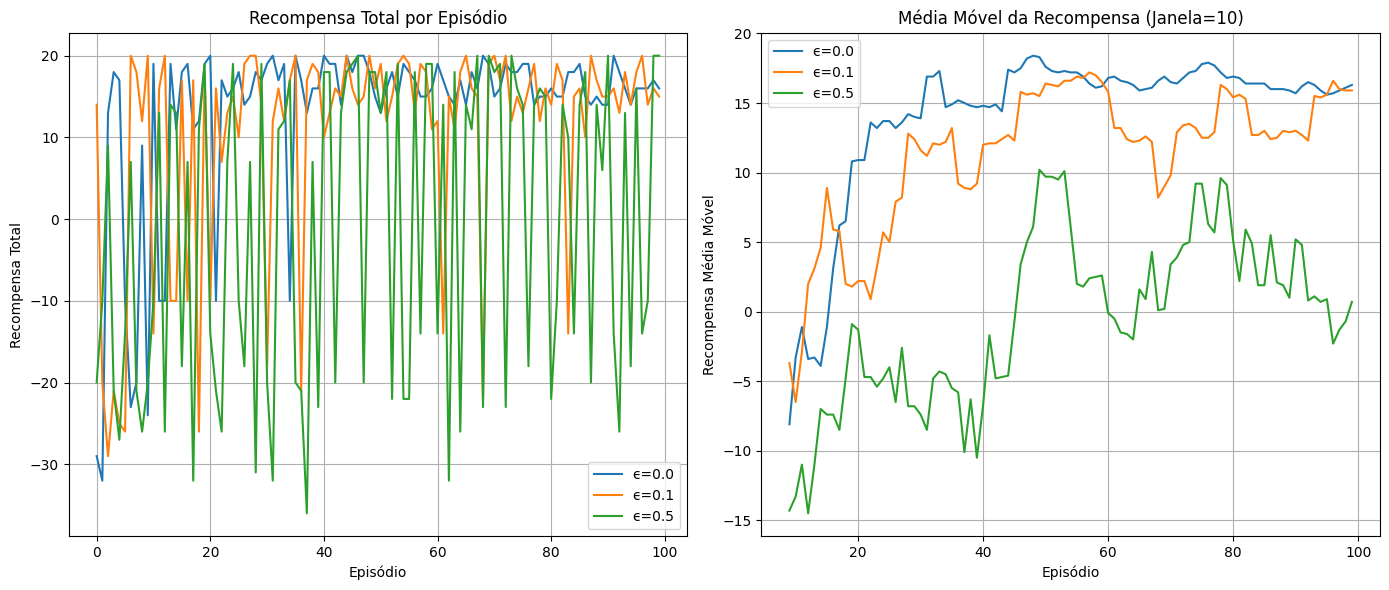


--- Tabela Q Final (ϵ=0.1) ---
Nota: -inf indica movimentos impossíveis (paredes)


,"Coords (L, C)",CIMA,DIREITA,BAIXO,ESQUERDA
State Index,,,,,
0,"[1, 1]",-1.071722,5.468818,-inf,-inf
1,"[1, 2]",11.142471,-4.000000,-inf,-0.865759
2,"[1, 3]",0.000000,0.000000,-inf,0.000000
3,"[1, 4]",1.058662,-inf,-inf,-4.000000
4,"[2, 1]",-0.975731,12.247148,-0.724572,-inf
5,"[2, 2]",-1.788818,14.290114,1.074421,-0.730549
6,"[2, 3]",16.099650,1.143238,-9.760000,6.474782
7,"[2, 4]",3.439013,-inf,-0.200000,12.770810
8,"[3, 1]",-1.063775,-1.419286,8.239139,-inf



--- Teste de Validação (Greedy partindo de [1, 1]) ---
Início: [1, 1]
Ação: DIREITA -> Novo Estado: [1, 2] (Reward: -1)
Ação: CIMA -> Novo Estado: [2, 2] (Reward: -1)
Ação: DIREITA -> Novo Estado: [2, 3] (Reward: -1)
Ação: CIMA -> Novo Estado: [3, 3] (Reward: -1)
Ação: DIREITA -> Novo Estado: [3, 4] (Reward: -1)
Ação: CIMA -> Novo Estado: [4, 4] (Reward: 20)
Terminou!


In [6]:
# --- 4. Visualização e Análise de Desempenho ---

import pandas as pd
import matplotlib.pyplot as plt

# 4.1 Definição dos Experimentos
EPSILON_TESTS = [0.0, 0.1, 0.5] # Valores a serem testados: Greedy Puro, Padrão, Alta Exploração
results = {}

print("Iniciando Experimento de Variação de Epsilon...")

for test_epsilon in EPSILON_TESTS:
    # Executa o treinamento e armazena a Q-Table final e as recompensas
    q_table_final, rewards = qlearning_execution(test_epsilon)
    results[test_epsilon] = {
        'rewards': rewards,
        'q_table': q_table_final
    }
    print(f"Treinamento com ϵ={test_epsilon} concluído.")


# 4.2 Geração dos Gráficos de Desempenho
WINDOW_SIZE = 10 # Tamanho da janela para a média móvel

plt.figure(figsize=(14, 6))

# Plot 1: Recompensa por Episódio
plt.subplot(1, 2, 1)
for epsilon, data in results.items():
    plt.plot(data['rewards'], label=f'ϵ={epsilon}')
plt.title('Recompensa Total por Episódio')
plt.xlabel('Episódio')
plt.ylabel('Recompensa Total')
plt.legend()
plt.grid(True)
plt.savefig('recompensa_por_episodio.png')


# Plot 2: Média Móvel (Rolling Mean) da Recompensa
plt.subplot(1, 2, 2)
for epsilon, data in results.items():
    mean_rewards = pd.Series(data['rewards']).rolling(window=WINDOW_SIZE).mean()
    plt.plot(mean_rewards, label=f'ϵ={epsilon}')
plt.title(f'Média Móvel da Recompensa (Janela={WINDOW_SIZE})')
plt.xlabel('Episódio')
plt.ylabel(f'Recompensa Média Móvel')
plt.legend()
plt.grid(True)
plt.savefig('media_movel_recompensa.png')

plt.tight_layout()
plt.show()

# 4.3 Visualização da Q-Table final (usando o melhor epsilon, que é 0.1)
best_q_table = results[0.1]['q_table']

def show_q_table(q_table):
    df = pd.DataFrame(q_table, columns=ACTIONS)
    df.index.name = "State Index"

    # Adicionar coluna legível de coordenadas para facilitar correção
    coords = [str(pos2k(i)) for i in range(16)]
    df.insert(0, "Coords (L, C)", coords)

    print("\n--- Tabela Q Final (ϵ=0.1) ---")
    print("Nota: -inf indica movimentos impossíveis (paredes)")
    return df

display_df = show_q_table(best_q_table)
display(display_df)

# 4.4 Teste Simples: Executar uma vez puramente guloso (Greedy)
print("\n--- Teste de Validação (Greedy partindo de [1, 1]) ---")
state = [1, 1]
print(f"Início: {state}")
for _ in range(10):
    # Usa a Q-Table aprendida com ϵ=0.1, mas a política é Greedy (epsilon=0)
    action = epsilon_greedy_policy(best_q_table, state, epsilon=0)
    state = rollout(state, action)
    reward, done = get_reward_and_status(state)
    print(f"Ação: {ACTIONS[action]} -> Novo Estado: {state} (Reward: {reward})")
    if done:
        print("Terminou!")
        break